# Semi Supervised Learning - Co-Training Model

This notebook is to perform semi-supervised learning by using the co-training algorithm from the baseline model. The baseline model is developed in `CSI5155 Project - baseline.ipynb`.

## Import Necessary Packages

In [1]:
import numpy as np;
import os;
import sys;
import joblib;
import random;
from sklearn.model_selection import train_test_split;
import json;
import pandas as pd;
import matplotlib.pyplot as plt;
# importing custom modules
sys.path.append("../Assignment 1 - Model Comparison/");
from fileOrganizer import unpack;
from performance import evalAccuracy, evalPrecision, evalRecall, evalF1Score, printConfMtx, plotROC;
import constants;
from model.cotraining import random_split_features, pca_based_split, correlation_based_split, importance_based_split, evaluate_feature_split_methods, plot_confusion_matrix, plot_roc_curve;

## Load the Data

Original Dataset (without labelling/unlabelling, but normalized)

In [2]:
mush_X_train_norm = joblib.load(os.path.join(
    os.pardir,
    constants.ASM1_DIR,
    constants.MUSH_DIR,
    constants.TRAIN_DIR,
    constants.X_TRAIN_NORMALIZED_FILENAME
));
print("Number of Normalized Samples in Training Set: ", len(mush_X_train_norm));
print("Number of Features in the Normalized Training Set: ", len(mush_X_train_norm[random.randint(0, len(mush_X_train_norm)-1)]));
print("Value range of the original Training Set: ", np.min(mush_X_train_norm), np.max(mush_X_train_norm));

Number of Normalized Samples in Training Set:  1256
Number of Features in the Normalized Training Set:  12
Value range of the original Training Set:  -4.827248760778992 13.457018899436779


In [3]:
mush_y_train_norm = joblib.load(os.path.join(
    os.pardir,
    constants.ASM1_DIR,
    constants.MUSH_DIR,
    constants.TRAIN_DIR,
    constants.Y_TRAIN_NORMALIZED_FILENAME
));
print("Number of Samples in Training Set: ", len(mush_y_train_norm));
print("Unique Labels in Training Set: ", np.unique(mush_y_train_norm));

Number of Samples in Training Set:  1256
Unique Labels in Training Set:  [0 1]


In [4]:
mush_X_test_norm = joblib.load(os.path.join(
    os.pardir,
    constants.ASM1_DIR,
    constants.MUSH_DIR,
    constants.TEST_DIR,
    constants.X_TEST_NORMALIZED_FILENAME
));
print("Number of Normalized Samples in Testing Set: ", len(mush_X_test_norm));
print("Number of Features in the Normalized Testing Set: ", len(mush_X_test_norm[random.randint(0, len(mush_X_test_norm)-1)]));
print("Value range of the Normalized Testing Set: ", np.min(mush_X_test_norm), np.max(mush_X_test_norm));

Number of Normalized Samples in Testing Set:  629
Number of Features in the Normalized Testing Set:  12
Value range of the Normalized Testing Set:  -4.827248760778992 13.457018899436779


In [5]:
mush_y_test_norm = joblib.load(os.path.join(
    os.pardir,
    constants.ASM1_DIR,
    constants.MUSH_DIR,
    constants.TEST_DIR,
    constants.Y_TEST_NORMALIZED_FILENAME
));
print("Number of Samples in Testing Set: ", len(mush_y_test_norm));
print("Unique Labels in Testing Set: ", np.unique(mush_y_test_norm));

Number of Samples in Testing Set:  629
Unique Labels in Testing Set:  [0 1]


Labelled Data

In [6]:
X_train_labelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.X_TRAIN_LABELLED_FILENAME
));
print("Number of Labelled Samples: ", len(X_train_labelled));
print("Number of Features in the Labelled Training Set: ", len(X_train_labelled[random.randint(0, len(X_train_labelled)-1)]));
print("Value range of the Labelled Training Set: ", np.min(X_train_labelled), np.max(X_train_labelled));

Number of Labelled Samples:  251
Number of Features in the Labelled Training Set:  12
Value range of the Labelled Training Set:  -4.827248760778992 3.262658784576777


In [7]:
y_train_labelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.Y_TRAIN_LABELLED_FILENAME
));
print("Number of Labelled Labels: ", len(y_train_labelled));
print("Unique Labels: ", np.unique(y_train_labelled));

Number of Labelled Labels:  251
Unique Labels:  [0 1]


Unlabelled Data

In [8]:
X_train_unlabelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.X_TRAIN_UNLABELLED_FILENAME
));
print("Number of Unlabelled Samples: ", len(X_train_unlabelled));
print("Number of Features in the Unlabelled Training Set: ", len(X_train_unlabelled[random.randint(0, len(X_train_unlabelled)-1)]));
print("Value range of the Unlabelled Training Set: ", np.min(X_train_unlabelled), np.max(X_train_unlabelled));

Number of Unlabelled Samples:  1005
Number of Features in the Unlabelled Training Set:  12
Value range of the Unlabelled Training Set:  -4.827248760778992 13.457018899436779


In [9]:
# This is the true labels for the supposedly unlabelled data
# for debugging purpose!!!
y_train_unlabelled = unpack(os.path.join(
    constants.TRAIN_DIR,
    constants.Y_TRAIN_UNLABELLED_FILENAME
));
print("Number of Unlabelled Labels: ", len(y_train_unlabelled));
print("Unique Labels: ", np.unique(y_train_unlabelled));

Number of Unlabelled Labels:  1005
Unique Labels:  [0 1]


Test Data

In [10]:
mush_X_test_norm = joblib.load(os.path.join(
    os.pardir,
    constants.ASM1_DIR,
    constants.MUSH_DIR,
    constants.TEST_DIR,
    constants.X_TEST_NORMALIZED_FILENAME
));
print("Number of Normalized Samples in Testing Set: ", len(mush_X_test_norm));
print("Number of Features in the Normalized Testing Set: ", len(mush_X_test_norm[random.randint(0, len(mush_X_test_norm)-1)]));
print("Value range of the Normalized Testing Set: ", np.min(mush_X_test_norm), np.max(mush_X_test_norm));

Number of Normalized Samples in Testing Set:  629
Number of Features in the Normalized Testing Set:  12
Value range of the Normalized Testing Set:  -4.827248760778992 13.457018899436779


In [11]:
mush_y_test_norm = joblib.load(os.path.join(
    os.pardir,
    constants.ASM1_DIR,
    constants.MUSH_DIR,
    constants.TEST_DIR,
    constants.Y_TEST_NORMALIZED_FILENAME
));
print("Number of Samples in Testing Set: ", len(mush_y_test_norm));
print("Unique Labels in Testing Set: ", np.unique(mush_y_test_norm));

Number of Samples in Testing Set:  629
Unique Labels in Testing Set:  [0 1]


## Load the Column Names

In [12]:
columns = joblib.load(os.path.join(
    constants.COLUMNS_DIR,
    constants.COLUMNS_FILENAME
));
print("Columns in a sample: ", columns);

Columns in a sample:  ['age' 'gender' 'education' 'country' 'ethnicity' 'nscore' 'escore'
 'oscore' 'ascore' 'cscore' 'impuslive' 'ss']


## Load the Model

Note: We already trained the Gradient Boosting classifier with the labelled data in this notebook `CSI5155 Project - baseline.ipynb`. We load 2 models to perform co-training on a subset of features in the data in each classifier.

In [13]:
model1 = unpack(os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_FILENAME
));
model1

RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': array([ 6,  8,  4, 14, 12,  9,  9,  3,  7, 17, 19,  1, 19, 17, 15, 12, 16,
       18,  2,  8, 15,  9, 12,  2,  8, 17, 11,  1, 14, 15, 13,  4,  1, 19,
       12, 15,  6, 19,  9, 17, 10, 12, 16,  3,  5, 13, 10, 19,  5,  5,  4,
       10,  6,  4,  5,  2, 17,  1,  1,  5, 10,  1, 10, 11,  8, 14, 13, 12,
        8, 17, 14,  1,  3,  4, 19, 10,  6, 19, 14,  2, 19, 15, 13,  7,  5,
        3,  4,  3, 14, 10,  5, 16, 10,  5, 16, 15,  4,  8, 17,  8],
      dtype=int64),
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000194E4FDE620>},
                   random_state=42)

In [14]:
model2 = unpack(os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_FILENAME
));
model2

RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                   param_distributions={'max_depth': array([ 6,  8,  4, 14, 12,  9,  9,  3,  7, 17, 19,  1, 19, 17, 15, 12, 16,
       18,  2,  8, 15,  9, 12,  2,  8, 17, 11,  1, 14, 15, 13,  4,  1, 19,
       12, 15,  6, 19,  9, 17, 10, 12, 16,  3,  5, 13, 10, 19,  5,  5,  4,
       10,  6,  4,  5,  2, 17,  1,  1,  5, 10,  1, 10, 11,  8, 14, 13, 12,
        8, 17, 14,  1,  3,  4, 19, 10,  6, 19, 14,  2, 19, 15, 13,  7,  5,
        3,  4,  3, 14, 10,  5, 16, 10,  5, 16, 15,  4,  8, 17,  8],
      dtype=int64),
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000194E4FDFA30>},
                   random_state=42)

## Co-Training Algorithm

We now intend to train 2 classifiers so that they iteratively label each other's
unlabeled instances

### Compare and Experiment whichever method we should use to split our features in the co-training algorithm.


=== Evaluating with View Size Ratio: 0.3 ===

=== Evaluating Method: random_split_features ===
Number of features in view 1: 3
Number of features in view 2: 9
Method: random_split_features | AUC: 0.7718 | Accuracy: 0.6836

=== Evaluating Method: pca_based_split ===
Number of features in view 1: 6
Number of features in view 2: 6
Method: pca_based_split | AUC: 0.7584 | Accuracy: 0.6884

=== Evaluating Method: correlation_based_split ===
Features in View 1:  [10  9 11]
Features in View 2:  [0 1 2 3 4 5 6 7 8]
Method: correlation_based_split | AUC: 0.7791 | Accuracy: 0.6932

=== Evaluating Method: importance_based_split ===
Features in View 1:  [3 9 0]
Features in View 2:  [10  6  8 11  7  5  1  2  4]
Method: importance_based_split | AUC: 0.7766 | Accuracy: 0.6948

=== Evaluating with View Size Ratio: 0.5 ===

=== Evaluating Method: random_split_features ===
Number of features in view 1: 6
Number of features in view 2: 6
Method: random_split_features | AUC: 0.7872 | Accuracy: 0.6995

=== 

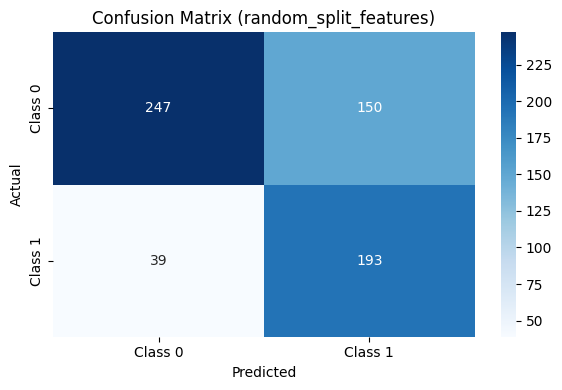

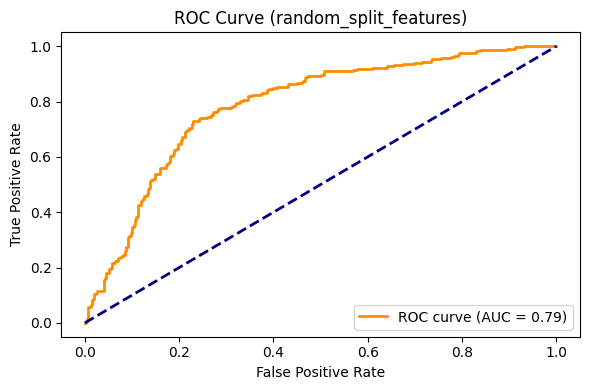


Best Method: random_split_features
Best Result: {'method': 'random_split_features', 'features_view1': [2, 0, 6, 5, 1, 7], 'features_view2': [4, 3, 8, 11, 10, 9], 'auc': 0.7872187961434899, 'accuracy': 0.699523052464229, 'y_pred': [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 

In [15]:
# Prepare the data
X_train = mush_X_train_norm
X_test = mush_X_test_norm
y_train = mush_y_train_norm
y_test = mush_y_test_norm

# Define the feature selection methods
methods = [random_split_features, pca_based_split, correlation_based_split, importance_based_split]

# Evaluate each method
view_size_ratios = [0.3, 0.5, 0.7]  # Try different feature size ratios
all_results = []

for ratio in view_size_ratios:
    print(f"\n=== Evaluating with View Size Ratio: {ratio} ===")
    best_method, ratio_results = evaluate_feature_split_methods(
        methods, X_train_labelled, mush_X_test_norm, y_train_labelled, mush_y_test_norm, view_size_ratio=ratio
    )
    all_results.extend(ratio_results)

# Save the results to a JSON file
with open('feature_split_comparison_results.json', 'w') as f:
    json.dump(all_results, f, indent=4)

# Find the best result
best_result = max(all_results, key=lambda x: x['auc'])

# Plot the confusion matrix and ROC curve for the best method
plot_confusion_matrix(y_test, best_result['y_pred'], best_result['method'])
plot_roc_curve(y_test, best_result['y_pred_proba'], best_result['auc'], best_result['method'])

print("\nBest Method:", best_result['method'])
print("Best Result:", best_result)
joblib.dump(best_result, os.path.join(
    constants.MODEL_DIR,
    constants.CO_TRAINING_BEST_FEATURE_SPLIT_RESULTS_FILENAME
));

### Data Preparation

In [16]:
features_view1 = best_result["features_view1"]
features_view2 = best_result["features_view2"];
X_train_labelled_1 = [];
X_train_labelled_2 = [];
X_train_unlabelled_1 = [];
X_train_unlabelled_2 = [];
X_test_splitted_1 = [];
X_test_splitted_2 = [];
# labelled training data
for sample_labelled in X_train_labelled:
    new_sample_view1 = [];
    new_sample_view2 = [];
    for featureInd in range(len(sample_labelled)):
        if (featureInd in features_view1):
            new_sample_view1.append(sample_labelled[featureInd]);
        if (featureInd in features_view2):
            new_sample_view2.append(sample_labelled[featureInd]);
    X_train_labelled_1.append(new_sample_view1);
    X_train_labelled_2.append(new_sample_view2);
# unlabelled training data
for sample_unlabelled in X_train_unlabelled:
    new_sample_view1 = [];
    new_sample_view2 = [];
    for featureInd in range(len(sample_unlabelled)):
        if (featureInd in features_view1):
            new_sample_view1.append(sample_unlabelled[featureInd]);
        if (featureInd in features_view2):
            new_sample_view2.append(sample_unlabelled[featureInd]);
    X_train_unlabelled_1.append(new_sample_view1);
    X_train_unlabelled_2.append(new_sample_view2);
# test data
for sample_test in X_test:
    new_sample_view1 = [];
    new_sample_view2 = [];
    for featureInd in range(len(sample_test)):
        if (featureInd in features_view1):
            new_sample_view1.append(sample_test[featureInd]);
        if (featureInd in features_view2):
            new_sample_view2.append(sample_test[featureInd]);
    X_test_splitted_1.append(new_sample_view1);
    X_test_splitted_2.append(new_sample_view2);
# columns
columns_view1 = [];
columns_view2 = [];
for i in range(len(columns)):
    column = columns[i];
    if (i in features_view1):
        columns_view1.append(column);
    if (i in features_view2):
        columns_view2.append(column);

In [17]:
print("Number of Samples in Classifier 1: ", len(X_train_labelled_1));
print("Number of Samples in Classifier 2: ", len(X_train_labelled_2));
print("Number of Features in the first Labelled Training Set: ", len(X_train_labelled_1[random.randint(0, len(X_train_labelled_1)-1)]));
print("Number of Features in the second Labelled Training Set: ", len(X_train_labelled_2[random.randint(0, len(X_train_labelled_2)-1)]));

Number of Samples in Classifier 1:  251
Number of Samples in Classifier 2:  251
Number of Features in the first Labelled Training Set:  6
Number of Features in the second Labelled Training Set:  6


In [18]:
print("Number of Unlabelled Samples in the first set: ", len(X_train_unlabelled_1));
print("Number of Unlabelled Samples in the second set: ", len(X_train_unlabelled_2));
print("Number of Features in the first Unlabelled Training Set: ", len(X_train_unlabelled_1[random.randint(0, len(X_train_unlabelled_1)-1)]));
print("Number of Features in the second Unlabelled Training Set: ", len(X_train_unlabelled_2[random.randint(0, len(X_train_unlabelled_2)-1)]));

Number of Unlabelled Samples in the first set:  1005
Number of Unlabelled Samples in the second set:  1005
Number of Features in the first Unlabelled Training Set:  6
Number of Features in the second Unlabelled Training Set:  6


In [19]:
print("Number of Test Samples in the first set: ", len(X_test_splitted_1));
print("Number of Test Samples in the second set: ", len(X_test_splitted_2));
print("Number of Features in the first Test Set: ", len(X_test_splitted_1[random.randint(0, len(X_test_splitted_1)-1)]));
print("Number of Features in the second Test Set: ", len(X_test_splitted_2[random.randint(0, len(X_test_splitted_2)-1)]));

Number of Test Samples in the first set:  629
Number of Test Samples in the second set:  629
Number of Features in the first Test Set:  6
Number of Features in the second Test Set:  6


In [20]:
print("Columns in a sample for training the 1st classifier: ", columns_view1);
print("Columns in a sample for training the 2nd classifier: ", columns_view2);

Columns in a sample for training the 1st classifier:  ['age', 'gender', 'education', 'nscore', 'escore', 'oscore']
Columns in a sample for training the 2nd classifier:  ['country', 'ethnicity', 'ascore', 'cscore', 'impuslive', 'ss']


## Train the Replicated Models

In [21]:
model1.fit(X_train_labelled_1, y_train_labelled);

In [22]:
model2.fit(X_train_labelled_2, y_train_labelled);

### Generate the Pseudo-Labels for Unlabelled Data from Predictions

In [23]:
y_pred_1 = model1.predict_proba(X_train_unlabelled_1);
print("Number of Predictions by the 1st classifier: ", len(y_pred_1));
# probablistic prediction: each number represents the probability of the sample being in the corresponding class
print("Number of items in the Prediction by the 1st classifier: ", len(y_pred_1[random.randint(0, len(y_pred_1)-1)]));
print("Value range of the Prediction by the 1st classifier: ", np.min(y_pred_1), np.max(y_pred_1));

Number of Predictions by the 1st classifier:  1005
Number of items in the Prediction by the 1st classifier:  2
Value range of the Prediction by the 1st classifier:  0.0036989564732136104 0.9963010435267864


In [24]:
y_pred_2 = model2.predict_proba(X_train_unlabelled_2);
print("Number of Predictions by the 2nd classifier: ", len(y_pred_2));
# probablistic prediction: each number represents the probability of the sample being in the corresponding class
print("Number of items in the Prediction by the 2nd classifier: ", len(y_pred_2[random.randint(0, len(y_pred_2)-1)]));
print("Value range of the Prediction by the 2nd classifier: ", np.min(y_pred_2), np.max(y_pred_2));

Number of Predictions by the 2nd classifier:  1005
Number of items in the Prediction by the 2nd classifier:  2
Value range of the Prediction by the 2nd classifier:  0.004531471765318438 0.9954685282346816


#### Format the predictions array

In [25]:
y_pred_1 = np.argmax(y_pred_1, axis=1);
print("Number of Predictions by the 1st classifier: ", len(y_pred_1));
print("Unique Predictions by the 1st classifier: ", np.unique(y_pred_1));

Number of Predictions by the 1st classifier:  1005
Unique Predictions by the 1st classifier:  [0 1]


In [26]:
y_pred_2 = np.argmax(y_pred_2, axis=1);
print("Number of Predictions by the 2nd classifier: ", len(y_pred_2));
print("Unique Predictions by the 2nd classifier: ", np.unique(y_pred_2));

Number of Predictions by the 2nd classifier:  1005
Unique Predictions by the 2nd classifier:  [0 1]


## Train the Models again with pseudo-labels

In [27]:
model1.fit(X_train_unlabelled_1, y_pred_1);

In [28]:
model2.fit(X_train_unlabelled_2, y_pred_2);

In [29]:
# save the models
joblib.dump(model1, os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_COTRAIN_1_FILENAME
));
joblib.dump(model2, os.path.join(
    constants.MODEL_DIR,
    constants.MODEL_COTRAIN_2_FILENAME
));

## Evaluation

### Make Predictions on the Test Set

In [30]:
y_pred_test_1 = model1.predict(X_test_splitted_1);
print("Number of Predictions made: ", len(y_pred_test_1));
print("Unique Predictions: ", np.unique(y_pred_test_1));

Number of Predictions made:  629
Unique Predictions:  [0 1]


In [31]:
y_pred_test_2 = model2.predict(X_test_splitted_2);
print("Number of Predictions made: ", len(y_pred_test_2));
print("Unique Predictions: ", np.unique(y_pred_test_2));

Number of Predictions made:  629
Unique Predictions:  [0 1]


### Choose a Predicted Value to trust with

In [32]:
assert(len(y_pred_test_1) == len(y_pred_test_2));
# decide the final prediction based on random split
y_pred_test = [];
for i in range(len(y_pred_test_1)):
    if y_pred_test_1[i] == y_pred_test_2[i]:
        y_pred_test.append(y_pred_test_1[i]);
    else:
        y_pred_test.append(random.choice([y_pred_test_1[i], y_pred_test_2[i]]));
y_pred_test = np.array(y_pred_test);
print("Number of Predictions made: ", len(y_pred_test));
print("Unique Predictions: ", np.unique(y_pred_test));

Number of Predictions made:  629
Unique Predictions:  [0 1]


### Evaluate the Metrics

In [33]:
evalArr = y_pred_test == y_test;
print("Number of correct predictions: ", len(evalArr[evalArr == True]));
print("Number of incorrect predictions: ", len(evalArr[evalArr == False]));

Number of correct predictions:  464
Number of incorrect predictions:  165


In [34]:
accuracy = evalAccuracy(y_pred_test, y_test);
precision = evalPrecision(y_pred_test, y_test);
recall = evalRecall(y_pred_test, y_test);
f1Score = evalF1Score(y_pred_test, y_test);
print("Accuracy: ", accuracy);
print("Precision: ", precision);
print("Recall: ", recall);
print("F1 Score: ", f1Score);

Accuracy:  0.7376788553259142
Precision:  0.6425531914893617
Recall:  0.6508620689655172
F1 Score:  0.6466809421841542


### Print the Confusion Matrix from the Test Set

In [35]:
printConfMtx(y_pred_test, y_test)

Predicted,user,non-user,All
Actual,,,
user,151,81,232
non-user,84,313,397
All,235,394,629


### Display the ROC Curve and its Area Under the Curve (AUC)

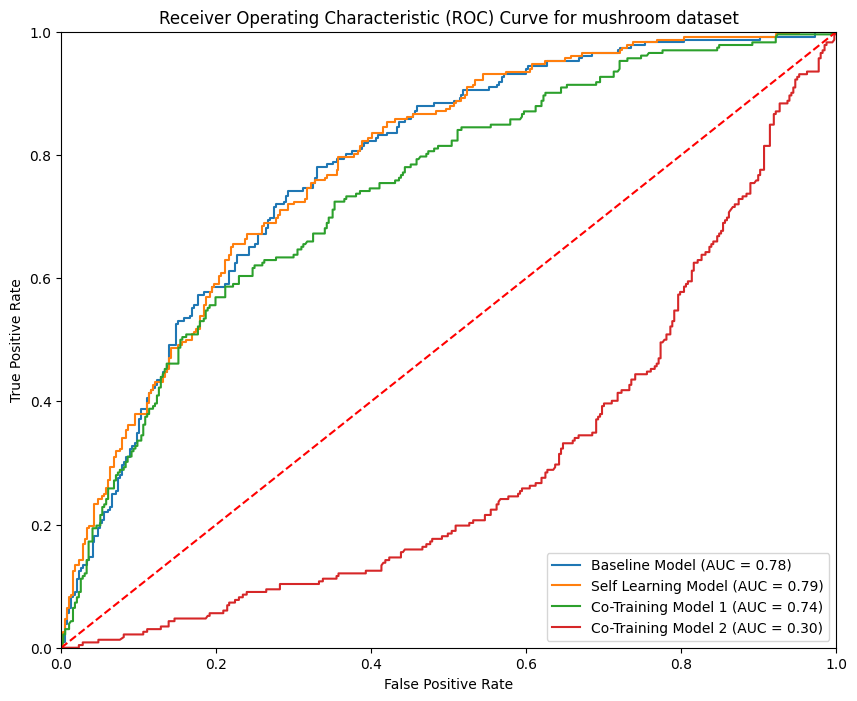

AUC of the Baseline Model: 0.7812907148440892
AUC of the Self Learning Model: 0.7852970555024754
AUC of the 1st Co-Training Model: 0.7422207504560062
AUC of the 2nd Co-Training Model: 0.2978589420654912


In [37]:
AUC_baseline, AUC_selftraining, AUC_cotraining1, AUC_cotraining2 = plotROC(
    models={
        "Baseline Model": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_FILENAME
        )),
        "Self Learning Model": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_SELFTRAIN_FILENAME
        )),
        "Co-Training Model 1": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_COTRAIN_1_FILENAME
        )),
        "Co-Training Model 2": joblib.load(os.path.join(
            constants.MODEL_DIR,
            constants.MODEL_COTRAIN_2_FILENAME
        ))
    },
    X_test=X_test,
    y_test=y_test,
    feature_subsets={
        "Co-Training Model 1": best_result["features_view1"],
        "Co-Training Model 2": best_result["features_view2"],
    },
    dataset="mushroom"
);
print(f"AUC of the Baseline Model: {AUC_baseline}");
print(f"AUC of the Self Learning Model: {AUC_selftraining}");
print(f"AUC of the 1st Co-Training Model: {AUC_cotraining1}");
print(f"AUC of the 2nd Co-Training Model: {AUC_cotraining2}");